# Introduction of analog Hamiltonian simulation

Analog Hamiltonian Simulation (AHS) is a quantum computing paradigm different from gate-based computing. AHS uses a well-controlled quantum system and tunes its parameters to mimic the dynamics of another quantum system, the one we aim to study. 

In the gate-based quantum computation, the program is a quantum circuit consisting of a series of quantum gates, each of which acts only a small subset of qubits. In contrast, an AHS program is a sequence of time-dependent Hamiltonians that govern the quantum dynamics of all qubits. The comparison can be seen in the following figure, where the left side shows a typical quantum circuit, and the right side illustrates that, during AHS, the effect of the evolution under a Hamiltonian can be understood as a unitary acting simultaneously on all qubits.

Digital quantum circuit             |   Analog Hamiltonian Simulation
:-------------------------:|:-------------------------:
<img src="digital.png" alt="digital quantum computing" width="400"/>  |  <img src="analog.png" alt="analog hamiltonian simulation" width="600"/>

("Digital quantum circuit" and "Analog Hamiltonian Simulation" figures by [QuEra Computing Inc.](https://www.quera.com/) are licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/))

In this notebook, we focus on running Analog Hamiltonian Simulations with Rydberg atoms. Also, we will use `matplotlib` package and `ahs_utils.py` module in the current working directory for visualization purposes.

# AHS with Rydberg atoms

An Analog Hamiltonian Simulation **program** is fully specified by its quantum register and (time-dependent) Hamiltonian.

In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

register = AtomArrangement()
H = Hamiltonian()

ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=H,
    register=register
)

In order to run AHS program with Rydberg atoms, we will first have to understand what type of Hamiltonian can Rydberg atoms simulate.

## Introduction to Rydberg Hamiltonian

Depending on the atomic states we use for the Rydberg system, its Hamiltonian could take different forms. Here we shall focus on the following type of Hamiltonian

\begin{align}
H(t) = \sum_{k=1}^N H_{\text{drive}, k}(t) + \sum_{k=1}^N H_{\text{shift}, k}(t) + \sum_{j=1}^{N-1}\sum_{k = j+1}^N H_{\text{vdW}, j, k},
\end{align}

where $j, k=1,2,\ldots N$ index the atoms (qubits) in the program register. We describe the nature and effect of each term in the Hamiltonian in the following sections, using a triangular array as an example.

### Register

First, we need to define a quantum **register**, 2-dimensional layout of neutral atoms, on which this Hamiltonian will act.

In [2]:
import numpy as np

# e.g. three atoms in an equilateral triangle, with pairwise
# separation equal to 5.5 micrometers
a = 5.5e-6  # meters

register.add([0, 0])
register.add([a, 0.0])
register.add([0.5 * a, np.sqrt(3)/2 * a]);

The atom arrangement can be visualized in the following way

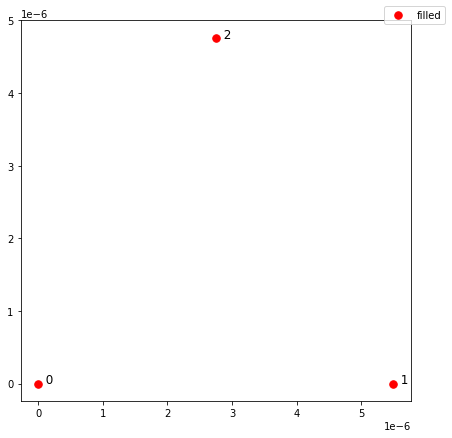

In [3]:
from ahs_utils import show_register

show_register(register)

### Driving field

The first term of the Hamiltonian represents the effect of a **driving field** that addresses the atoms simultaneously and uniformly

\begin{align}
H_{\text{drive}, k}(t) = \frac{\Omega(t)}{2}\left(e^{i\phi(t)}|g_k\rangle\langle r_k| + e^{-i\phi(t)}|r_k\rangle\langle g_k|\right) - \Delta_\text{global}(t)n_k,
\end{align}

where $\Omega$, $\phi$, and $\Delta_\text{global}$ to denote the **amplitude** (Rabi frequency), laser **phase**, and the **detuning** of the driving laser field. Here $n_k = |r_k\rangle\langle r_k|$ is the number operator of atom $k$; the kets $|g_k\rangle$ and $|r_k\rangle$ denote the ground and Rydberg states, respectively. The $\Omega$ part of the driving term is identical to a uniform (time-dependent) _transverse_ magnetic field, whereas the $\Delta_\text{global}$ part implements the effect of a _longitudinal_ magnetic field, in a spin-model representation.

For the purpose of this example, we choose a constant Rabi frequency equal to $\Omega_\text{max}=2.5\times10^6$ rad/s, with the phase and global detuning set to zero. The duration of the program is set to $\frac{\pi}{\sqrt{2}\Omega_\text{max}}$, which will be explained in the next section. 

In [4]:
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

# e.g. trapzoid amplitude time series
Omega_max = 2.5e6  # rad / seconds

# e.g. the duration of the program
t_max = np.pi/(np.sqrt(2)*Omega_max) # seconds

# e.g. constant Rabi frequency
Omega = TimeSeries()
Omega.put(0.0, Omega_max)
Omega.put(t_max, Omega_max)

# e.g. all-zero phase and detuning
phi = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad])
Delta_global = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad/s])

drive = DrivingField(
    amplitude=Omega,
    phase=phi,
    detuning=Delta_global
)

H += drive

### Shifting field

The second term in $H(t)$ represents the effect of a **shifting field** that detunes atoms according to a non-uniform pattern.

\begin{align}
H_{\text{shift}, k}(t) = -\Delta_\text{local}(t)h_k \,n_k,
\end{align}

where $\Delta_\text{local}(t)$ is the time-dependent **magnitude** of the frequency shift, and $h_k$ is the atom-dependent **pattern**, which is a dimensionless number between 0 and 1. This shifting term is identical to a non-uniform (and time-dependent) _longitudinal_ magnetic field in a spin-model representation.

For the purpose of this example, we choose a shifting field that strongly detunes the top atom in the triangular lattice.

In [5]:
from braket.ahs.field import Field
from braket.ahs.pattern import Pattern
from braket.ahs.shifting_field import ShiftingField

# e.g. constant strong shifting field
Delta_local = TimeSeries()
Delta_local.put(0.0, -Omega_max*20)  # (time [s], value [rad/s])
Delta_local.put(t_max, -Omega_max*20)


# e.g. the shifting field only acts on the third atom, 
# which is the top atom in the triangular array.
h = Pattern([0, 0, 0.5])

shift = ShiftingField(
    magnitude=Field(
        time_series=Delta_local,
        pattern=h
    )
)

H += shift

The driving field and the shifting field can be inspected with the following utility function

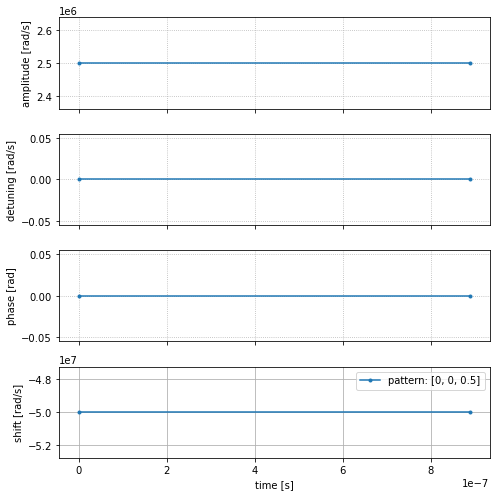

In [6]:
from ahs_utils import show_drive_and_shift

show_drive_and_shift(drive, shift)

### Rydberg-Rydberg interaction

Finally, the third term in $H(t)$ is the van der Waals interaction between all pairs of Rydberg atoms,

\begin{align}
H_{\text{vdW}, j, k} =V_{j,k} \,n_j\, n_k = \frac{C_6}{R_{j,k}^6} \,n_j\, n_k,
\end{align}

where $C_6$ is a fixed interaction coefficient, and $R_{j,k}=|{\bf x}_j-{\bf x}_k|$ is the distance between atoms $j$ and $k$. This interaction shifts the frequency of the Rydberg level of all atoms that are close to an atom that is already in its Rydberg state. While the overall coefficient, $C_6$ is a fixed value (determined by the nature of the ground and Rydberg states), the strength of this interaction can be tuned by adjusting the pairwise distance $R_{j,k}$ between atoms.

In [7]:
# Note:
# The van der Waals interaction term is implicitly assumed in the current version of the AHS module,
# its strength (C6 / R_{j,k}^6) is calculated (if using the local simulator) from the atomic positions 
# of the register, hence there is no need to specify it explicitly.

**Introduction to Rydberg blockade**

For the interaction coefficient, the value of $C_6$ depends on the atom species, and the states used in the simulation. Here we shall take the value 

\begin{align}
C_6 = 5.42\times 10^{-24} ~\text{rad}~ \text{m}^6/\text{s}
\end{align}

for $|r\rangle = |70S_{1/2}\rangle$ of the $^{87}$Rb atoms. For the typical scenario, where atoms are separated by $4\times10^{-6}$ meters, the van der Waals interaction strength is $V_{jk}=1.32\times10^9 \text{rad}/\text{s}$, which is much larger than the typical scale of the Rabi frequency (around $6\times10^6 \text{rad}/\text{s}$). As a result, when the separation of two atoms is within certain distance, it is nearly impossible to drive them to the Rydberg state simultaneously. 

This is called the Rydberg blockade phenomena, illustrated in the figure below (Source: [Browaeys and Lahaye](https://arxiv.org/abs/2002.07413)), where $R$ is the separation between the atoms, and $E$ indicates the energies or frequencies of the different two-atom states as $R$ changes. The vertical arrows indicate the effect of a uniform driving field (with Rabi frequency $\Omega$) that successfully transitions the atoms from the $|gg\rangle$ ground state to the 1-atom excited state $|\psi_+\rangle = (|gr\rangle + |rg\rangle)/\sqrt{2}$ (independent of $R$), but fails to get from there to the doubly-excited state $|rr\rangle$, if $R$ is smaller than $R_b = (C_6 / \Omega)^{1/6}$, the blockade radius.

<u>Note</u>: In the presence of both global Rabi frequency and detuning, it is more accurate to estimate the blockade radius with $R_b = (C_6 / \sqrt{\Omega^2+\Delta^2})^{1/6}$, see [Pichler, et. al.](https://arxiv.org/abs/1808.10816).

<img src="Blockade.png" alt="drawing" style="width:250px;"/>

### Full program

The fully-specified program can be inspected with the following command.

In [8]:
ahs_program.to_ir().dict()

{'braketSchemaHeader': {'name': 'braket.ir.ahs.program', 'version': '1'},
 'setup': {'ahs_register': {'sites': [[Decimal('0'), Decimal('0')],
    [Decimal('0.0000055'), Decimal('0.0')],
    [Decimal('0.00000275'), Decimal('0.000004763139720814412')]],
   'filling': [1, 1, 1]}},
 'hamiltonian': {'drivingFields': [{'amplitude': {'time_series': {'values': [Decimal('2500000.0'),
       Decimal('2500000.0')],
      'times': [Decimal('0.0'), Decimal('8.885765876316732E-7')]},
     'pattern': 'uniform'},
    'phase': {'time_series': {'values': [Decimal('0.0'), Decimal('0.0')],
      'times': [Decimal('0.0'), Decimal('8.885765876316732E-7')]},
     'pattern': 'uniform'},
    'detuning': {'time_series': {'values': [Decimal('0.0'), Decimal('0.0')],
      'times': [Decimal('0.0'), Decimal('8.885765876316732E-7')]},
     'pattern': 'uniform'}}],
  'shiftingFields': [{'magnitude': {'time_series': {'values': [Decimal('-50000000.0'),
       Decimal('-50000000.0')],
      'times': [Decimal('0.0'), Dec

# Running AHS program with local simulator

The AHS program defined above realizes the maximally entangled state for a pair of atoms, out of the three atoms in the triangular array. To see that, recall that we have subjected the top atom in the triangular array (labeled as atom 2) with a strong detuning $H_{\text{shift}, 2}(t) = -\frac{1}{2}\Delta_\text{local}n_2$ where $\Delta_\text{local}=-10\Omega_\text{max}=-2.5\times10^7$ rad/s. Since $\Delta_\text{local}$ is much bigger than any other energy scales in the system, including the Rabi frequency, it is energy unfavorable for atom 2 to be excited to the Rydberg state (note the minus sign in $H_{\text{shift}, 2}(t)$). Hence atom 2 remains in the ground state throughout the evolution, and can be neglected in the following analysis.

Since the other two atoms are subjected with only the driving field with zero detuning and phase, the constant Hamiltonian reads
\begin{align}
H = \frac{\Omega}{2}\sum_{k=0}^1\left(|g_k\rangle\langle r_k| + |r_k\rangle\langle g_k|\right) + V_{0,1}{n}_0{n}_1,
\end{align}
where $k=0,1$ are the indices for the two lower atoms in the triangular array. More concretely, in the basis of $\left\{|gg\rangle, |gr\rangle, |rg\rangle, |rr\rangle\right\}$, the Hamiltonian takes the following matrix representation
\begin{align}
H = 
\begin{bmatrix}
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & 0 \\
\frac{\Omega}{2} & 0 & 0 & \frac{\Omega}{2}\\
\frac{\Omega}{2} & 0 & 0 & \frac{\Omega}{2}\\
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & V_{0,1}
\end{bmatrix}.
\end{align}
Since the two atoms are separated by $d_{0,1} = 5.5\times10^{-6}$ meters, the interaction strength between them reads
\begin{align}
V_{0,1}=\frac{C_6}{(d_{0,1})^6} = \frac{5.42\times10^{-24}}{(5.5\times10^{-6})^6}\approx1.96\times10^8 \text{ rad/s},
\end{align}
which is much greater than the Rabi frequency. Hence the two atoms are in the Rydberg blockade regime, and the state $|rr\rangle$ is very unlikely to be excited (assuming the initial state is $|gg\rangle$). Hence we can neglect the $|rr\rangle$ state, and the Hamiltonian is simplified to be
\begin{align}
H = 
\begin{bmatrix}
0 & \frac{\Omega}{2} & \frac{\Omega}{2} \\
\frac{\Omega}{2} & 0 & 0 \\
\frac{\Omega}{2} & 0 & 0 
\end{bmatrix},
\end{align}
and the final state of the evolution can be solved to be
\begin{align}
|\psi\rangle = e^{-iHt}|gg\rangle = 
\begin{bmatrix}
\cos\frac{\Omega t}{\sqrt{2}}\\
\frac{i}{\sqrt{2}}\sin\frac{\Omega t}{\sqrt{2}}\\
\frac{i}{\sqrt{2}}\sin\frac{\Omega t}{\sqrt{2}}
\end{bmatrix}.
\end{align}
Hence if the system evolves for a duration $T=\frac{\pi}{\sqrt{2}\Omega}$, which is indeed the duration of the AHS program defined in the previous section, we will arrive at a maximally entangled state between the two atoms
\begin{align}
|\psi\rangle = \frac{1}{\sqrt{2}}(|gr\rangle+|rg\rangle).
\end{align}

Before submitting the AHS program to a QPU, it is useful to run the program on the local simulator to check if the simulation result meets one's expectation. 

In [9]:
from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

We can run the AHS program just like running a quantum circuit on other Braket devices. Below we have explicitly specified the values of `steps` and `shots`, which are the number of time steps in the simulation and the number of sampling for the final stats, respectively. One could increase the accuracy of the result by increasing the values of these arguments, at the expense of longer runtime. 

In [10]:
result = device.run(ahs_program, shots=1000, steps=100).result()

To confirm that we indeed arrive at a maximally entangled state, we first collect the measurement results, followed by counting the number of occurrence of $|gr\rangle$ and $|rg\rangle$ respectively.

In [11]:
def get_counters_from_result(result):
    post_sequences = [list(measurement.post_sequence) for measurement in result.measurements]
    post_sequences = ["".join(['r' if site==0 else 'g' for site in post_sequence]) for post_sequence in post_sequences]

    counters = {}
    for post_sequence in post_sequences:
        if post_sequence in counters:
            counters[post_sequence] += 1
        else:
            counters[post_sequence] = 1
    return counters

get_counters_from_result(result)

{'ggr': 1, 'grg': 484, 'rgg': 515}

The simulation outcome indeed confirms our expectations
1. It is very unlikely to excite the 3rd atom to the Rydberg state because of the strong local detuning. 
2. Due to the Rydberg blockade, it is very unlikely to excite the 1st and 2nd atoms to the Rydberg states simultaneously.
3. By appropriately tuning the Rabi frequency and the duration of the AHS program, we can arrive at a maximally entangled state for the 1st and 2nd atoms. Since our simulation is noiseless, the discrepancy from ideal 50%-50% split is attributed to statistical sampling (aka "shot noise").

In summary, in this notebook, we have introduced Analog Hamiltonian Simulation (AHS), a different quantum computing paradigm, and showed how to run an AHS program with Rydberg atoms using Braket's local AHS simulator.